# Investment Strategy Backtesting Framework

This notebook demonstrates the complete usage of the backtesting framework developed for the M2 Quant project.

## Table of Contents
1. [Installation and imports](#installation)
2. [Data generation](#data)
3. [Built-in strategies](#built-in-strategies)
4. [Custom strategies](#custom-strategies)
5. [Running backtests](#backtesting)
6. [Results analysis](#analysis)
7. [Strategy comparison](#comparison)
8. [Advanced strategies](#advanced)

## 1. Installation and Imports <a id="installation"></a>

In [1]:
# Required imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Import backtesting framework
from backtesting_framework import (
    Backtester, 
    Strategy, 
    Result,
    strategy_decorator,
    compare_results
)

# Import example strategies
from strategies.buy_and_hold import BuyAndHoldStrategy
from strategies.moving_average_cross import MovingAverageCrossStrategy
from strategies.mean_reversion import MeanReversionStrategy

# Chart configuration
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

print("Backtesting framework imported successfully!")
print(f"Available visualization backends: {Result.get_available_backends()}")

Backtesting framework imported successfully!
Available visualization backends: ['matplotlib', 'seaborn', 'plotly']


## 2. Data Generation <a id="data"></a>

Load real market data from Yahoo Finance.

In [2]:
def load_price_data(start_date='2020-01-01', end_date='2023-12-31', ticker: str = 'AAPL'):
    """
    Load data from Yahoo Finance.

    Returns a DataFrame with columns: ['date','open','close','returns','high','low','volume']
    """

    df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    if df.empty:
        raise ValueError(f"No data returned by yfinance for ticker {ticker} in {start_date}:{end_date}")

    # Reset index
    df = df.reset_index()

    # Flatten MultiIndex if necessary
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join(map(str, c)).strip() for c in df.columns.values]

    # Detect and normalize columns based on substrings
    mapping = {}
    used_targets = set()
    for col in df.columns:
        lc = str(col).lower()
        if 'open' in lc and 'open' not in used_targets:
            mapping[col] = 'open'; used_targets.add('open')
        elif 'close' in lc and 'close' not in used_targets:
            mapping[col] = 'close'; used_targets.add('close')
        elif 'high' in lc and 'high' not in used_targets:
            mapping[col] = 'high'; used_targets.add('high')
        elif 'low' in lc and 'low' not in used_targets:
            mapping[col] = 'low'; used_targets.add('low')
        elif 'volume' in lc and 'volume' not in used_targets:
            mapping[col] = 'volume'; used_targets.add('volume')
        elif 'adj close' in lc or 'adj_close' in lc or lc.endswith('adjclose'):
            mapping[col] = 'adj_close'

    if mapping:
        df = df.rename(columns=mapping)

    # Determine date column
    date_candidates = [c for c in df.columns if 'date' in str(c).lower() or pd.api.types.is_datetime64_any_dtype(df[c])]
    if date_candidates:
        date_col = date_candidates[0]
    else:
        date_col = df.columns[0]

    expected_cols = [date_col, 'open', 'close', 'high', 'low', 'volume']
    missing = [c for c in expected_cols if c not in df.columns]
    if missing:
        found = list(df.columns)
        raise ValueError(f"Missing columns from yfinance: {missing}. Columns found: {found}")

    # Select and rename date column to 'date'
    df = df[expected_cols].rename(columns={date_col: 'date'})

    # Force numeric types
    for col in ['open', 'close', 'high', 'low', 'volume']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Calculate returns properly
    df['returns'] = df['close'].pct_change().fillna(0).astype(float)

    df_out = df[['date', 'open', 'close', 'returns', 'high', 'low', 'volume']]
    return df_out

# Load data (assuming yfinance is installed, default AAPL)
try:
    data = load_price_data(
        start_date='2020-01-01',
        end_date='2023-12-31',
        ticker='AAPL'
    )

    print(f"Data loaded: {len(data)} days from {data['date'].min()} to {data['date'].max()}")
    print(f"Initial price: {float(data['close'].iat[0]):.2f}, Final price: {float(data['close'].iat[-1]):.2f}")
    print(f"Total return: {(float(data['close'].iat[-1]) / float(data['close'].iat[0]) - 1) * 100:.2f}%")
except Exception as e:
    print('Error loading data:', e)
    raise

Data loaded: 1006 days from 2020-01-02 00:00:00 to 2023-12-29 00:00:00
Initial price: 72.47, Final price: 190.73
Total return: 163.19%


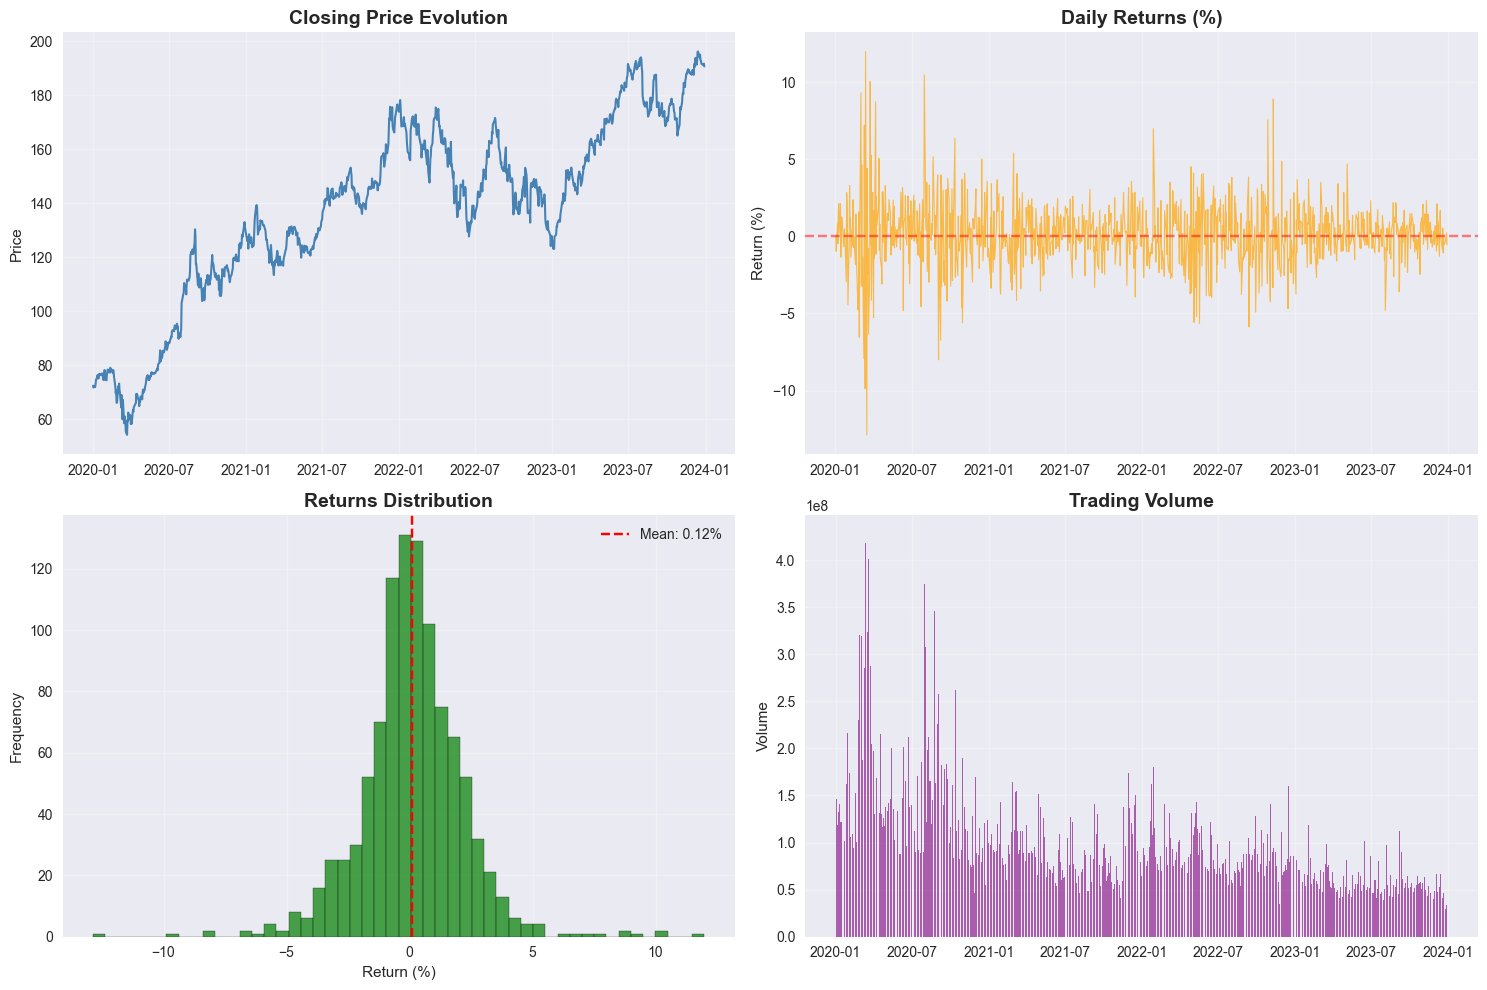


=== Data Statistics ===
Average daily return: 0.119%
Daily volatility: 2.114%
Annualized volatility: 33.55%
Sharpe ratio (annualized): 0.89
Total return over period: 163.19%


In [3]:
# Visualize loaded data
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Closing price
ax1.plot(data['date'], data['close'], linewidth=1.5, color='steelblue')
ax1.set_title('Closing Price Evolution', fontsize=14, fontweight='bold')
ax1.set_ylabel('Price')
ax1.grid(True, alpha=0.3)

# Daily returns
ax2.plot(data['date'], data['returns'] * 100, linewidth=0.8, alpha=0.7, color='orange')
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax2.set_title('Daily Returns (%)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Return (%)')
ax2.grid(True, alpha=0.3)

# Returns distribution
ax3.hist(data['returns'] * 100, bins=50, alpha=0.7, edgecolor='black', color='green')
ax3.axvline(x=data['returns'].mean() * 100, color='red', linestyle='--', 
           label=f'Mean: {data["returns"].mean() * 100:.2f}%')
ax3.set_title('Returns Distribution', fontsize=14, fontweight='bold')
ax3.set_xlabel('Return (%)')
ax3.set_ylabel('Frequency')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Volume
ax4.bar(data['date'], data['volume'], width=1, alpha=0.6, color='purple')
ax4.set_title('Trading Volume', fontsize=14, fontweight='bold')
ax4.set_ylabel('Volume')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Descriptive statistics
print("\n=== Data Statistics ===")
print(f"Average daily return: {data['returns'].mean() * 100:.3f}%")
print(f"Daily volatility: {data['returns'].std() * 100:.3f}%")
print(f"Annualized volatility: {data['returns'].std() * np.sqrt(252) * 100:.2f}%")
print(f"Sharpe ratio (annualized): {data['returns'].mean() / data['returns'].std() * np.sqrt(252):.2f}")
print(f"Total return over period: {(data['close'].iloc[-1] / data['close'].iloc[0] - 1) * 100:.2f}%")

## 3. Built-in Strategies <a id="built-in-strategies"></a>

The framework includes several ready-to-use strategies. Let's test them individually.

In [4]:
# Initialize backtester
backtester = Backtester(
    data=data,
    initial_capital=100000,
    transaction_cost=0.001,  # 0.1% per trade
    slippage=0.0005          # 0.05% slippage
)

print("Backtester initialized successfully!")
print(f"Initial capital: ${backtester.initial_capital:,.0f}")
print(f"Transaction costs: {backtester.transaction_cost * 100:.2f}%")
print(f"Slippage: {backtester.slippage * 100:.3f}%")
print(f"Backtest period: {len(backtester.data)} days")

Backtester initialized successfully!
Initial capital: $100,000
Transaction costs: 0.10%
Slippage: 0.050%
Backtest period: 1006 days


In [5]:
# Test Buy and Hold strategy
buy_hold_strategy = BuyAndHoldStrategy()
print(f"Strategy: {buy_hold_strategy}")

buy_hold_result = backtester.run_backtest(
    strategy=buy_hold_strategy,
    start_date='2020-01-01',
    end_date='2023-12-31'
)

print("\n=== Buy and Hold Results ===")
print(buy_hold_result.summary())

Strategy: Strategy: Buy and Hold (rebalance: D)

=== Buy and Hold Results ===
                       Metric Strategy Benchmark
0            Total Return (%)  165.38%   163.19%
1       Annualized Return (%)   27.73%    27.46%
2   Annualized Volatility (%)   33.56%    33.57%
3                Sharpe Ratio     0.83      0.82
4               Sortino Ratio     1.17         -
5        Maximum Drawdown (%)  -76.68%   -76.04%
6           Beta vs Benchmark     1.00      1.00
7      Alpha vs Benchmark (%)    0.24%     0.00%
8            Number of Trades     1005         -
9            % Winning Trades    52.6%         -
10      Transaction Costs (%)    0.10%     0.00%


In [6]:
# Test Moving Average Crossover strategy
ma_cross_strategy = MovingAverageCrossStrategy(short_window=10, long_window=30)
print(f"Strategy: {ma_cross_strategy}")

ma_cross_result = backtester.run_backtest(
    strategy=ma_cross_strategy,
    start_date='2020-01-01',
    end_date='2023-12-31'
)

print("\n=== Moving Average Cross Results ===")
print(ma_cross_result.summary())

Strategy: Strategy: MA Cross (10/30) (rebalance: D)

=== Moving Average Cross Results ===
                       Metric Strategy Benchmark
0            Total Return (%)   58.86%   163.19%
1       Annualized Return (%)   12.31%    27.46%
2   Annualized Volatility (%)   22.08%    33.57%
3                Sharpe Ratio     0.56      0.82
4               Sortino Ratio     0.66         -
5        Maximum Drawdown (%)  -52.22%   -76.04%
6           Beta vs Benchmark     0.43      1.00
7      Alpha vs Benchmark (%)    0.46%     0.00%
8            Number of Trades     1005         -
9            % Winning Trades    51.6%         -
10      Transaction Costs (%)    4.54%     0.00%


In [7]:
# Test Mean Reversion strategy
mean_reversion_strategy = MeanReversionStrategy(window=20, threshold=2.0)
print(f"Strategy: {mean_reversion_strategy}")

mean_reversion_result = backtester.run_backtest(
    strategy=mean_reversion_strategy,
    start_date='2020-01-01',
    end_date='2023-12-31'
)

print("\n=== Mean Reversion Results ===")
print(mean_reversion_result.summary())

Strategy: Strategy: Mean Reversion (BB 20, 2.0σ) (rebalance: D)

=== Mean Reversion Results ===
                       Metric Strategy Benchmark
0            Total Return (%)   61.55%   163.19%
1       Annualized Return (%)   12.78%    27.46%
2   Annualized Volatility (%)   18.45%    33.57%
3                Sharpe Ratio     0.69      0.82
4               Sortino Ratio     0.98         -
5        Maximum Drawdown (%)  -28.24%   -76.04%
6           Beta vs Benchmark     0.52      1.00
7      Alpha vs Benchmark (%)   -1.56%     0.00%
8            Number of Trades     1005         -
9            % Winning Trades    52.5%         -
10      Transaction Costs (%)    8.89%     0.00%


## 4. Creating Custom Strategies <a id="custom-strategies"></a>

The framework allows easy creation of custom strategies in two ways:
1. By inheriting from the `Strategy` class
2. By using the `@strategy_decorator`

**Note**: The framework supports long-only strategies (positions from 0 to 1). For multi-asset portfolios, use Dict-based API.

In [8]:
class RSIStrategy(Strategy):
    """
    Strategy based on RSI (Relative Strength Index) indicator.
    Buys when RSI < 30 (oversold), sells when RSI > 70 (overbought).
    """
    
    def __init__(self, window=14, oversold=30, overbought=70):
        self.window = window
        self.oversold = oversold
        self.overbought = overbought
        self.is_fitted = False
        self.rebalance_frequency = 'D'  # Daily rebalancing
    
    @property
    def name(self) -> str:
        return f"RSI Strategy ({self.window}, {self.oversold}, {self.overbought})"
    
    def calculate_rsi(self, prices, window):
        """Calculate RSI indicator."""
        if len(prices) < window + 1:
            return 50  # Neutral value if not enough data
        
        deltas = prices.diff().dropna()
        gains = deltas.where(deltas > 0, 0)
        losses = -deltas.where(deltas < 0, 0)
        
        avg_gains = gains.rolling(window).mean()
        avg_losses = losses.rolling(window).mean()
        
        rs = avg_gains / avg_losses
        rsi = 100 - (100 / (1 + rs))
        
        return rsi.iloc[-1] if not pd.isna(rsi.iloc[-1]) else 50
    
    def fit(self, historical_data: pd.DataFrame) -> None:
        """Training method (not needed for RSI)."""
        self.is_fitted = True
    
    def get_position(self, data: pd.DataFrame, positions: dict) -> dict:
        """Returns target position based on RSI (long-only: 0 to 1)."""
        if len(data) < self.window + 5:
            return {'asset': 0.0}  # Not enough data
        
        rsi = self.calculate_rsi(data['close'], self.window)
        
        if rsi < self.oversold:
            return {'asset': 1.0}  # Buy (oversold)
        elif rsi > self.overbought:
            return {'asset': 0.0}  # Sell to cash (overbought)
        else:
            return positions  # Keep current position

# Test RSI strategy
rsi_strategy = RSIStrategy(window=14, oversold=30, overbought=70)
rsi_result = backtester.run_backtest(rsi_strategy)

print(f"RSI Strategy created: {rsi_strategy.name}")
print(f"Number of trades: {len(rsi_result.trades)}")

RSI Strategy created: RSI Strategy (14, 30, 70)
Number of trades: 1005


In [9]:
# Method 2: Creating strategy with class (more reliable than decorator)
class MomentumStrategy(Strategy):
    """
    Simple momentum strategy:
    - Buy if current price > 20-day MA AND 5-day return > 2%
    - Sell if current price < 20-day MA AND 5-day return < -2%
    """
    
    def __init__(self):
        self.is_fitted = False
        self.rebalance_frequency = 'D'  # Daily rebalancing
    
    @property
    def name(self) -> str:
        return "Momentum Strategy"
    
    def fit(self, historical_data: pd.DataFrame) -> None:
        """Training method (not needed for momentum)."""
        self.is_fitted = True
    
    def get_position(self, data: pd.DataFrame, positions: dict) -> dict:
        """Returns target position based on momentum signals."""
        if len(data) < 25:
            return {'asset': 0.0}
        
        current_price = data['close'].iloc[-1]
        ma_20 = data['close'].rolling(20).mean().iloc[-1]
        
        # Calculate 5-day return
        price_5d_ago = data['close'].iloc[-6]
        return_5d = (current_price / price_5d_ago - 1) * 100
        
        if current_price > ma_20 and return_5d > 2:
            return {'asset': 1.0}  # Long position
        elif current_price < ma_20 and return_5d < -2:
            return {'asset': 0.0}  # To cash
        else:
            return positions  # Keep current position

# Test momentum strategy
momentum_strategy = MomentumStrategy()
momentum_result = backtester.run_backtest(momentum_strategy)

print(f"Momentum Strategy created: {momentum_strategy.name}")
print(f"Number of trades: {len(momentum_result.trades)}")

Momentum Strategy created: Momentum Strategy
Number of trades: 1005


In [10]:
# More complex strategy with simplified machine learning
class SimpleMLStrategy(Strategy):
    """
    Strategy using simple technical features and decision rules.
    """
    
    def __init__(self):
        self.features_history = []
        self.is_fitted = False
        self.rebalance_frequency = 'D'  # Daily rebalancing
    
    @property
    def name(self) -> str:
        return "Simple ML Strategy"
    
    def calculate_features(self, historical_data):
        """Calculate technical features."""
        if len(historical_data) < 30:
            return None
        
        prices = historical_data['close']
        
        # Technical features
        ma_5 = prices.rolling(5).mean().iloc[-1]
        ma_20 = prices.rolling(20).mean().iloc[-1]
        current_price = prices.iloc[-1]
        
        # Ratios
        price_to_ma5 = current_price / ma_5
        price_to_ma20 = current_price / ma_20
        ma5_to_ma20 = ma_5 / ma_20
        
        # Recent volatility
        recent_volatility = prices.pct_change().rolling(10).std().iloc[-1]
        
        # Momentum
        momentum_3d = (current_price / prices.iloc[-4] - 1) * 100
        momentum_10d = (current_price / prices.iloc[-11] - 1) * 100
        
        return {
            'price_to_ma5': price_to_ma5,
            'price_to_ma20': price_to_ma20,
            'ma5_to_ma20': ma5_to_ma20,
            'volatility': recent_volatility,
            'momentum_3d': momentum_3d,
            'momentum_10d': momentum_10d
        }
    
    def fit(self, historical_data: pd.DataFrame) -> None:
        """Training method (not needed for rule-based)."""
        self.is_fitted = True
    
    def get_position(self, data: pd.DataFrame, positions: dict) -> dict:
        """Returns position based on features (long-only: 0 to 1)."""
        features = self.calculate_features(data)
        if features is None:
            return {'asset': 0.0}
        
        # Simple decision rules based on features
        score = 0
        
        # Uptrend
        if features['ma5_to_ma20'] > 1.01:
            score += 1
        elif features['ma5_to_ma20'] < 0.99:
            score -= 1
        
        # Price vs averages
        if features['price_to_ma5'] > 1.02 and features['price_to_ma20'] > 1.05:
            score += 1
        elif features['price_to_ma5'] < 0.98 and features['price_to_ma20'] < 0.95:
            score -= 1
        
        # Momentum
        if features['momentum_3d'] > 2 and features['momentum_10d'] > 5:
            score += 1
        elif features['momentum_3d'] < -2 and features['momentum_10d'] < -5:
            score -= 1
        
        # Volatility adjustment
        if features['volatility'] > 0.03:  # High volatility
            score = score * 0.5  # Reduce exposure
        
        # Convert score to position (long-only)
        if score >= 2:
            return {'asset': 1.0}
        elif score <= -2:
            return {'asset': 0.0}
        elif score == 1:
            return {'asset': 0.5}
        elif score == -1:
            return {'asset': 0.3}
        else:
            return positions  # Keep current

# Test ML strategy
ml_strategy = SimpleMLStrategy()
ml_result = backtester.run_backtest(ml_strategy)

print(f"ML Strategy created: {ml_strategy.name}")
print(f"Number of trades: {len(ml_result.trades)}")

ML Strategy created: Simple ML Strategy
Number of trades: 1005


## 5. Running Backtests <a id="backtesting"></a>

Now that we have multiple strategies, let's run complete backtests and analyze the results.

In [ ]:
# Collect all results
all_results = {
    'Buy and Hold': buy_hold_result,
    'MA Cross': ma_cross_result,
    'Mean Reversion': mean_reversion_result,
    'RSI': rsi_result,
    'Momentum': momentum_result,
    'Simple ML': ml_result
}

print("=== Summary of All Strategies ===")
print(f"{'Strategy':<20} {'Total Return':<15} {'Sharpe':<8} {'Max DD':<8} {'Trades':<8}")
print("-" * 70)

for name, result in all_results.items():
    total_return = result.metrics['total_return'] * 100
    sharpe = result.metrics['sharpe_ratio']
    max_dd = result.metrics['max_drawdown'] * 100
    num_trades = result.metrics['num_trades']
    
    print(f"{name:<20} {total_return:>12.2f}% {sharpe:>7.2f} {max_dd:>7.2f}% {num_trades:>7d}")

=== Debug Info ===
Buy and Hold trades sample: [{'date': Timestamp('2020-01-03 00:00:00'), 'symbol': 'asset', 'price': np.float64(71.76371765136719), 'effective_price': np.float64(71.79959951019286), 'shares_traded': np.float64(1392.765428807214), 'trade_value': np.float64(100000.0), 'transaction_cost': np.float64(100.0), 'cash_before': 100000, 'cash_after': np.float64(-100.0), 'shares_before': 0.0, 'shares_after': np.float64(1392.765428807214), 'position_before': 0.0, 'position_after': np.float64(1.0)}, {'date': Timestamp('2020-01-06 00:00:00'), 'symbol': 'asset', 'price': np.float64(72.33558654785156), 'effective_price': np.float64(72.29941875457764), 'shares_traded': np.float64(-1.3831369839839618), 'trade_value': np.float64(-100.0), 'transaction_cost': np.float64(0.1), 'cash_before': np.float64(-100.0), 'cash_after': np.float64(-0.1), 'shares_before': np.float64(1392.765428807214), 'shares_after': np.float64(1391.38229182323), 'position_before': np.float64(1.0), 'position_after': n

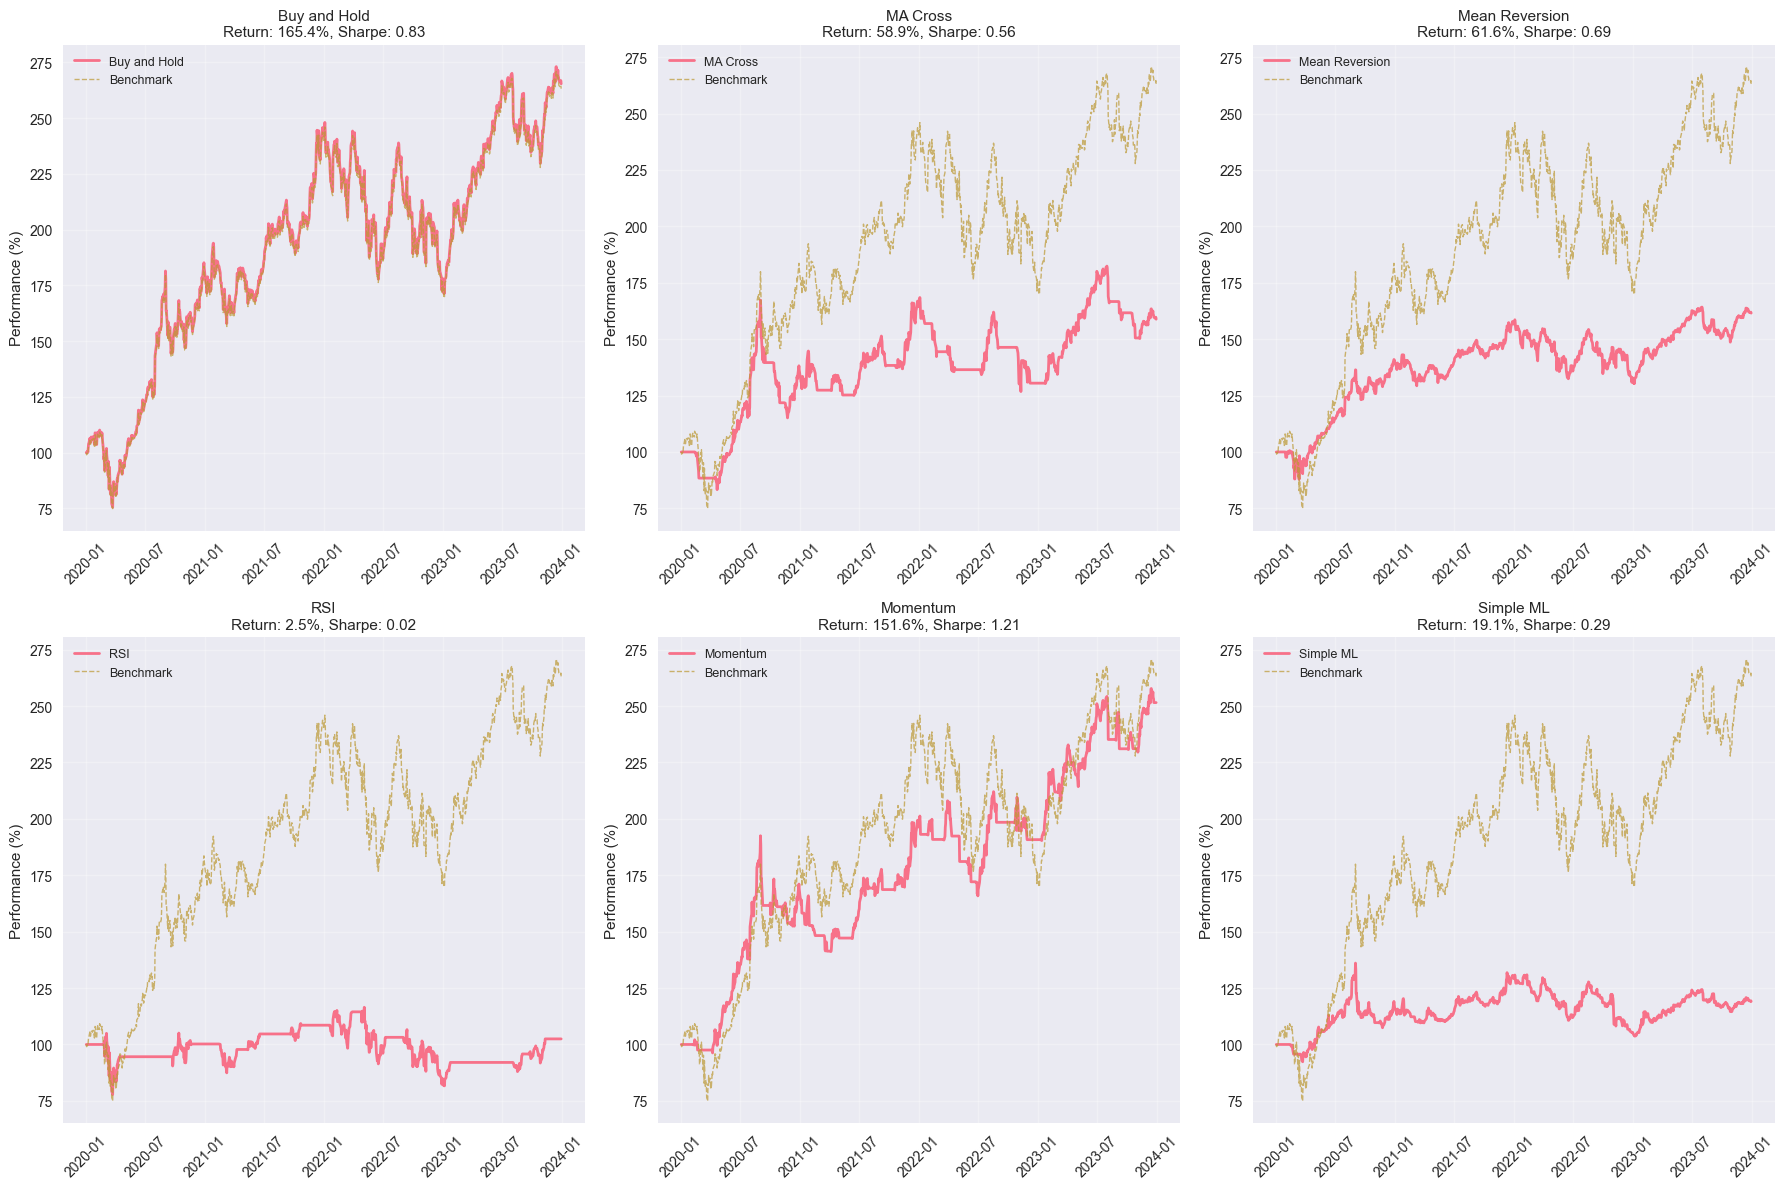

In [12]:
# Visualize performance of all strategies
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (name, result) in enumerate(all_results.items()):
    ax = axes[i]
    
    # Cumulative performance
    cumulative_perf = (1 + result.results_df['cumulative_returns']) * 100
    benchmark_perf = (1 + result.results_df['benchmark_cumulative']) * 100
    
    ax.plot(result.results_df.index, cumulative_perf, label=name, linewidth=2)
    ax.plot(result.results_df.index, benchmark_perf, label='Benchmark', 
           linewidth=1, alpha=0.7, linestyle='--')
    
    ax.set_title(f'{name}\nReturn: {result.metrics["total_return"]*100:.1f}%, ' +
                f'Sharpe: {result.metrics["sharpe_ratio"]:.2f}', fontsize=11)
    ax.set_ylabel('Performance (%)')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Rotate date labels for better readability
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 6. Detailed Results Analysis <a id="analysis"></a>

Let's analyze the best strategies in detail.

In [13]:
# Select best strategy based on Sharpe ratio
# Explicitly exclude 'Buy and Hold' strategy if present
try:
    candidates = {name: res for name, res in all_results.items() if name.lower() not in ('buy and hold', 'buy_and_hold')}
    if not candidates:
        # No candidates after exclusion: fall back to all strategies
        candidates = all_results

    best_strategy_name = max(candidates.keys(), key=lambda x: candidates[x].metrics['sharpe_ratio'])
    best_result = candidates[best_strategy_name]

    print(f"=== Detailed Analysis: {best_strategy_name} ===")
    print(best_result.summary())

    # Display detailed metrics
    print("\n=== Detailed Metrics ===")
    for metric, value in best_result.metrics.items():
        if isinstance(value, float):
            if 'return' in metric or 'alpha' in metric:
                print(f"{metric}: {value*100:.2f}%")
            elif 'ratio' in metric or 'beta' in metric:
                print(f"{metric}: {value:.3f}")
            else:
                print(f"{metric}: {value:.2f}")
        else:
            print(f"{metric}: {value}")
except Exception as e:
    print('Error selecting best strategy:', e)

=== Detailed Analysis: Momentum ===
                       Metric Strategy Benchmark
0            Total Return (%)  151.55%   163.19%
1       Annualized Return (%)   26.02%    27.46%
2   Annualized Volatility (%)   21.47%    33.57%
3                Sharpe Ratio     1.21      0.82
4               Sortino Ratio     1.45         -
5        Maximum Drawdown (%)  -51.35%   -76.04%
6           Beta vs Benchmark     0.40      1.00
7      Alpha vs Benchmark (%)   14.93%     0.00%
8            Number of Trades     1005         -
9            % Winning Trades    53.2%         -
10      Transaction Costs (%)   10.34%     0.00%

=== Detailed Metrics ===
total_return: 151.55%
benchmark_total_return: 163.19%
annualized_return: 26.02%
benchmark_annualized_return: 27.46%
volatility: 0.21
benchmark_volatility: 0.34
sharpe_ratio: 1.212
benchmark_sharpe_ratio: 0.818
max_drawdown: -0.51
benchmark_max_drawdown: -0.76
sortino_ratio: 1.447
num_trades: 1005
winning_trades_pct: 53.16
avg_trade_return: 0.20%
to

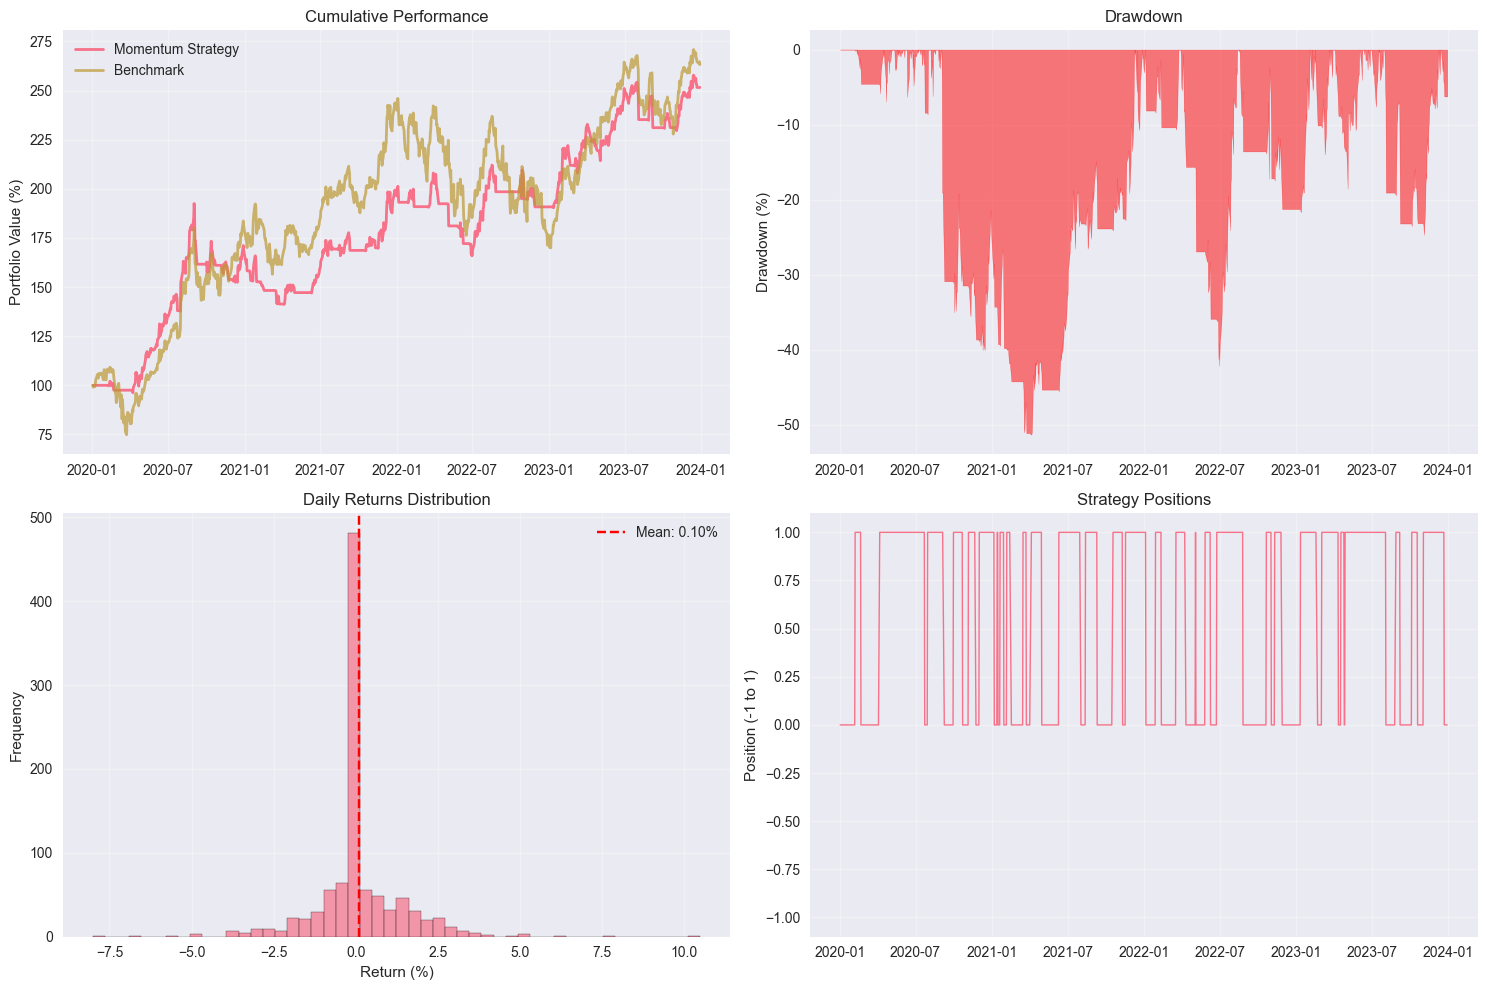

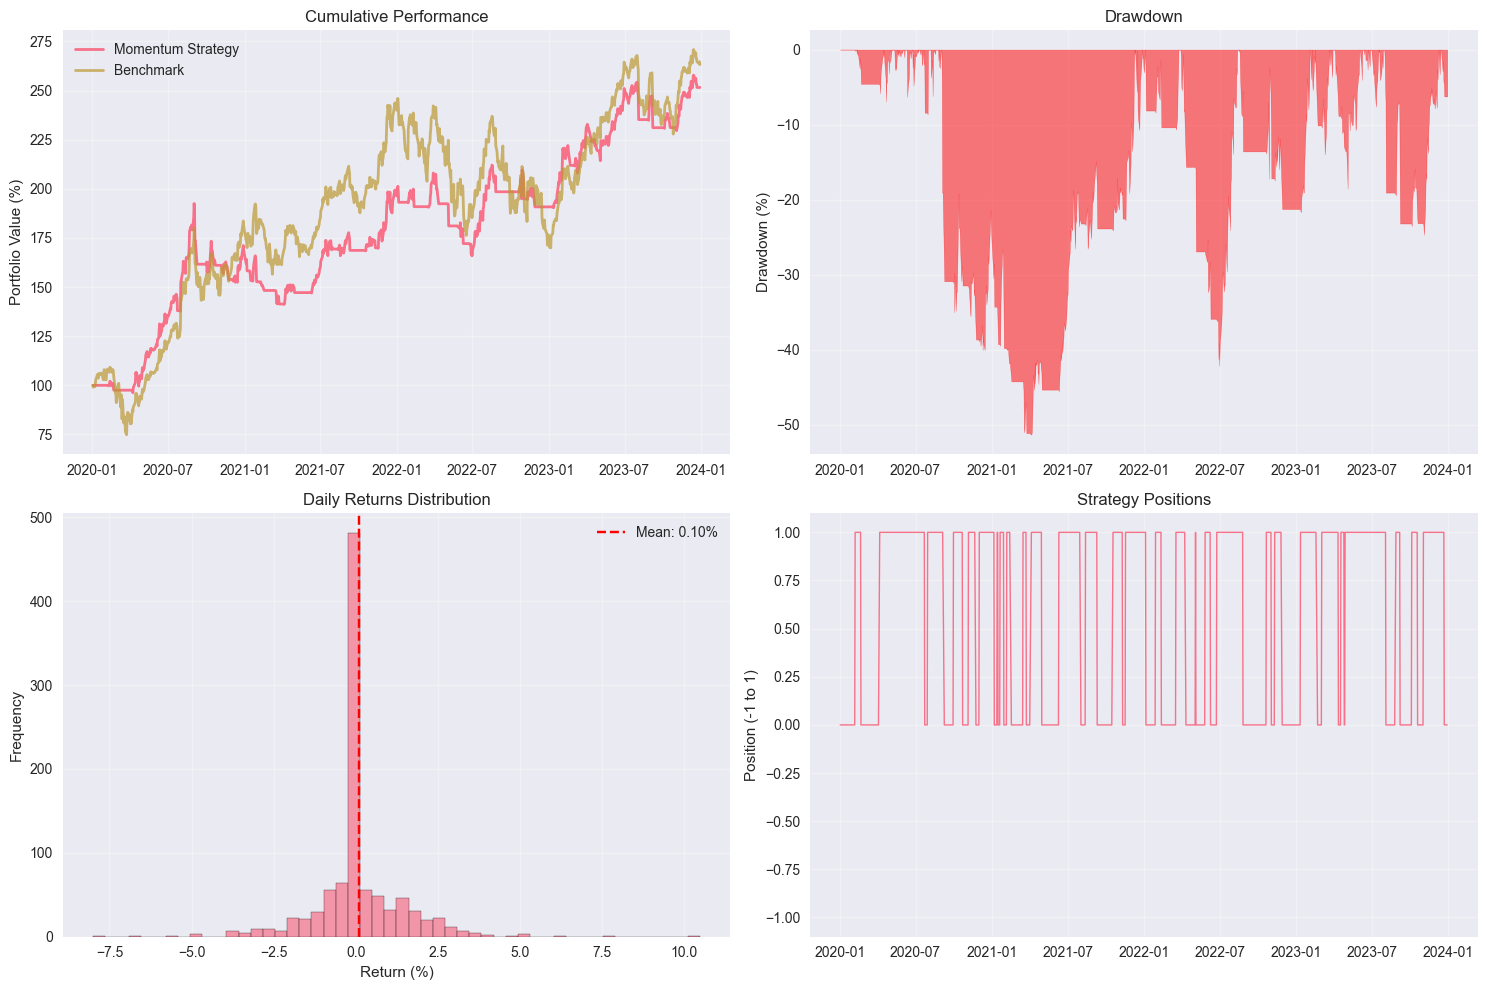

In [14]:
# Detailed visualization of best strategy
best_result.plot_performance(backend='matplotlib', figsize=(15, 10))

=== Trade Analysis: Momentum ===
Total number of trades: 1005
Average trade: $-161.09
Largest trade: $235,202.65
Smallest trade: $-251,930.83
Total transaction costs: $10,342.39


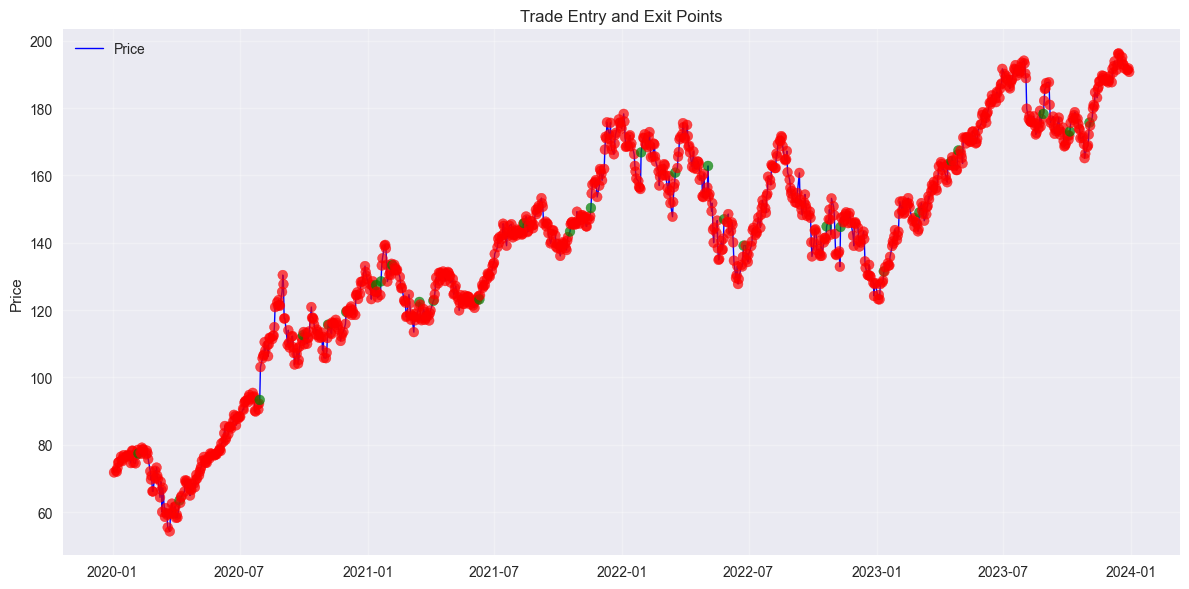

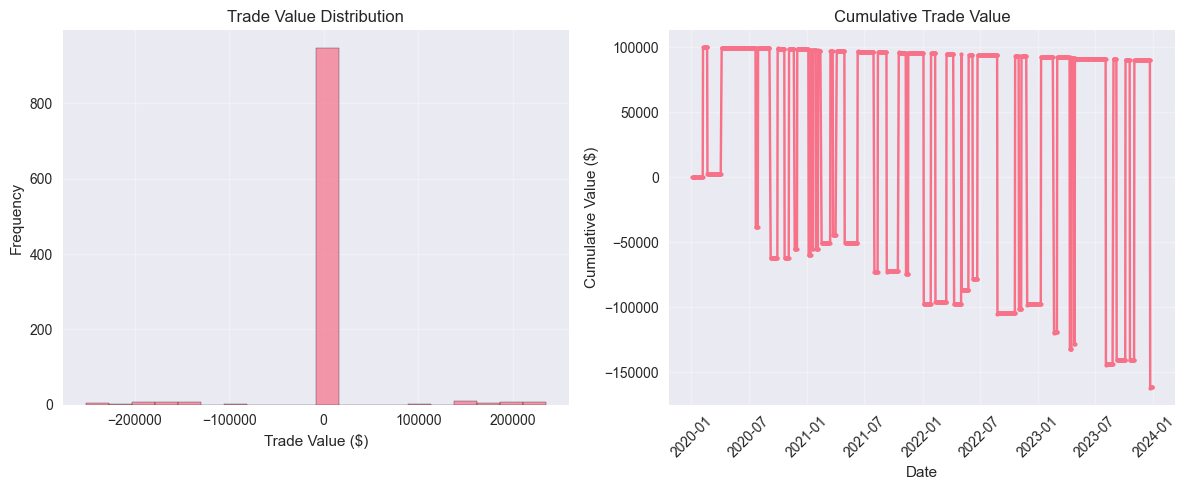

In [15]:
# Trade analysis for best strategy
if len(best_result.trades) > 0:
    trades_df = pd.DataFrame(best_result.trades)
    
    print(f"=== Trade Analysis: {best_strategy_name} ===")
    print(f"Total number of trades: {len(trades_df)}")
    print(f"Average trade: ${trades_df['trade_value'].mean():,.2f}")
    print(f"Largest trade: ${trades_df['trade_value'].max():,.2f}")
    print(f"Smallest trade: ${trades_df['trade_value'].min():,.2f}")
    print(f"Total transaction costs: ${trades_df['transaction_cost'].sum():,.2f}")
    
    # Trade visualization
    best_result.plot_trades(backend='matplotlib')
    
    # Trade size distribution
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(trades_df['trade_value'], bins=20, alpha=0.7, edgecolor='black')
    plt.title('Trade Value Distribution')
    plt.xlabel('Trade Value ($)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(trades_df['date'], trades_df['trade_value'].cumsum(), marker='o', markersize=3)
    plt.title('Cumulative Trade Value')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Value ($)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print(f"No trades executed for {best_strategy_name}")

## 7. Strategy Comparison <a id="comparison"></a>

Use the `compare_results` function to visually compare strategies.

=== Top 3 Strategies (by Sharpe ratio) ===
1. Momentum: Sharpe = 1.212
2. Mean Reversion: Sharpe = 0.693
3. MA Cross: Sharpe = 0.557


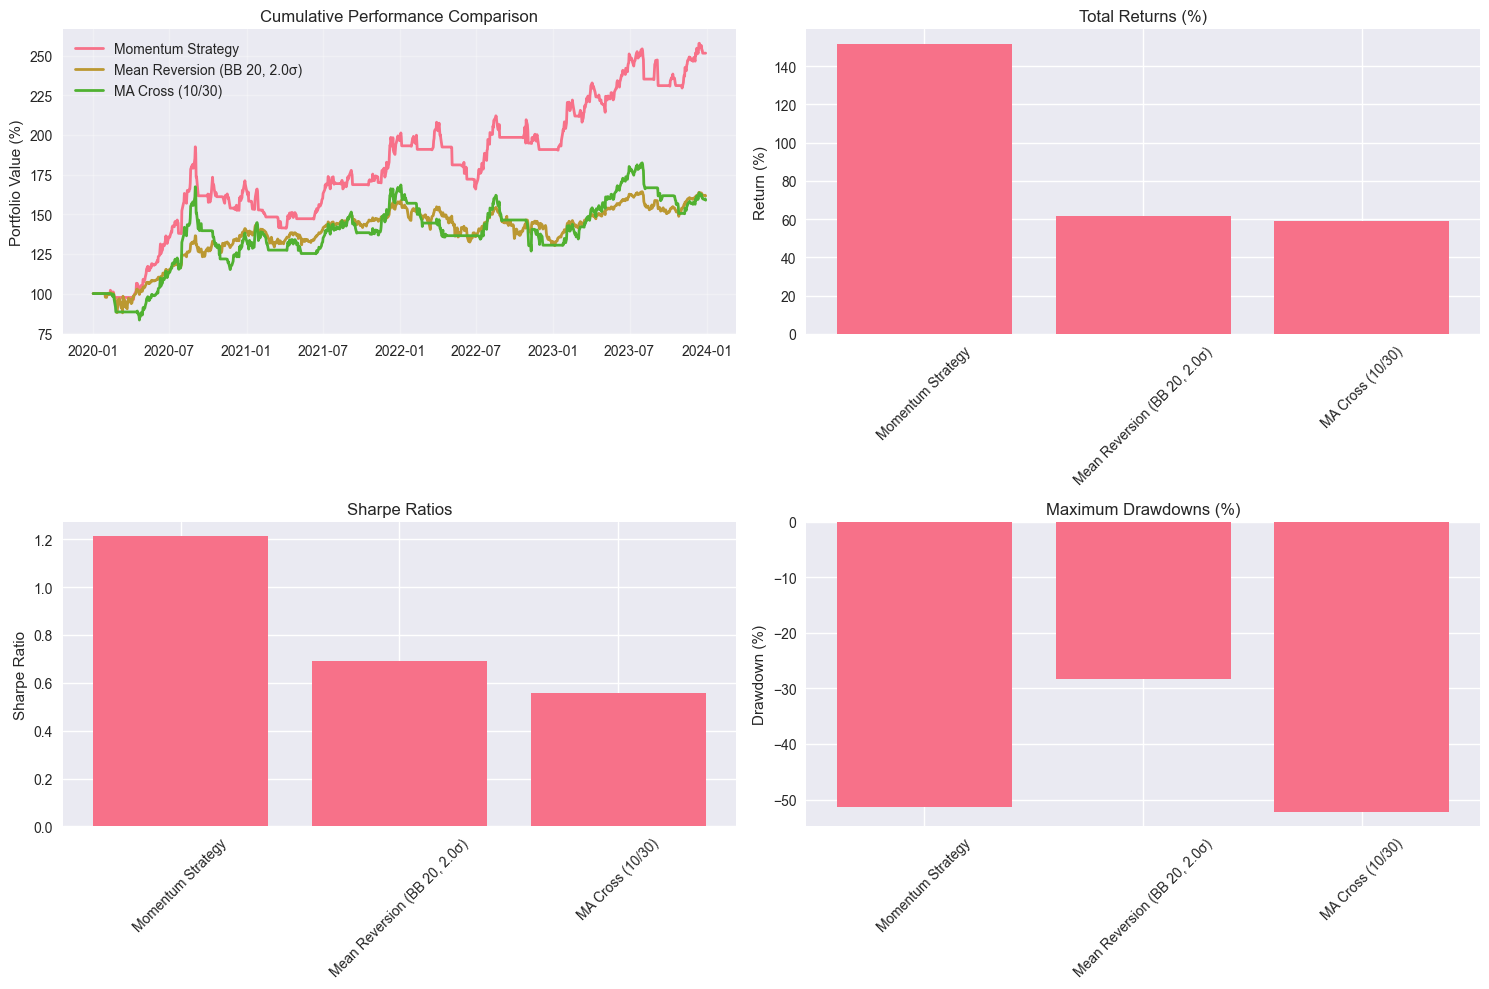

In [16]:
# Compare top 3 strategies
# Exclude 'Buy and Hold' from selection if present
candidates = [(name, res) for name, res in all_results.items() if name.lower() not in ('buy and hold', 'buy_and_hold')]
if not candidates:
    # If no candidates after exclusion, fall back to all strategies
    candidates = list(all_results.items())

sorted_strategies = sorted(candidates, key=lambda x: x[1].metrics['sharpe_ratio'], reverse=True)

# Take top 3 (or less if fewer available)
top_n = min(3, len(sorted_strategies))
top_3 = sorted_strategies[:top_n]

top_3_results = [result for name, result in top_3]
top_3_names = [name for name, result in top_3]

print(f"=== Top {top_n} Strategies (by Sharpe ratio) ===")
for i, (name, result) in enumerate(top_3, 1):
    print(f"{i}. {name}: Sharpe = {result.metrics['sharpe_ratio']:.3f}")

# Visual comparison (pass Result objects as arguments)
if top_3_results:
    compare_results(*top_3_results, backend='matplotlib')
else:
    print('No strategies to compare.')

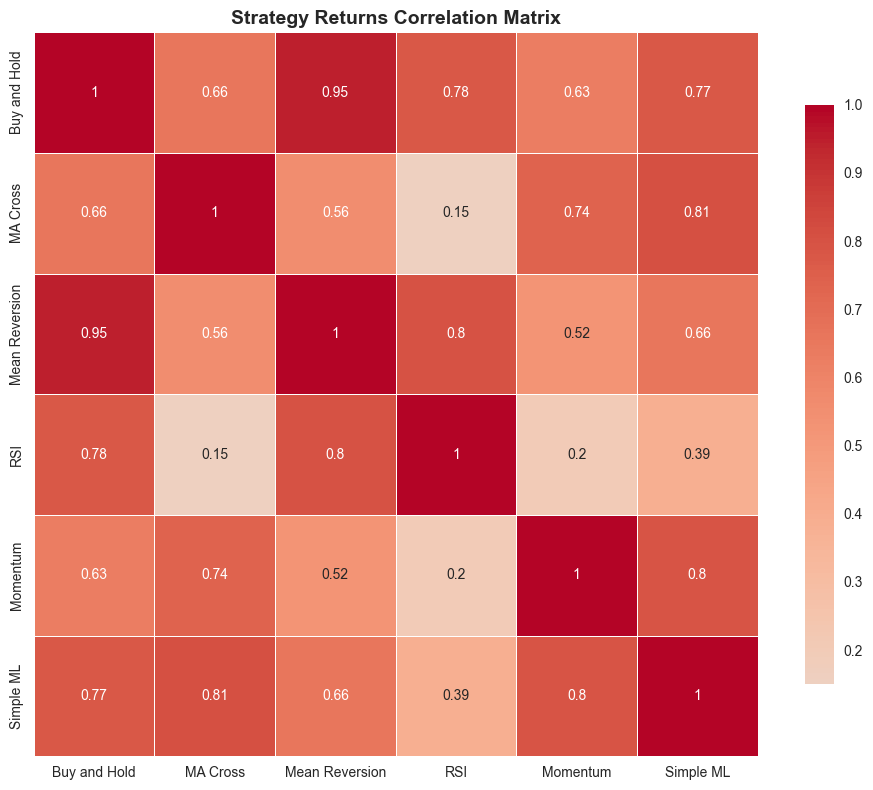

=== Correlation Analysis ===
Strongest correlations:
Buy and Hold vs Mean Reversion: 0.949
MA Cross vs Simple ML: 0.806
Mean Reversion vs RSI: 0.799
Momentum vs Simple ML: 0.797
Buy and Hold vs RSI: 0.780


In [17]:
# Strategy returns correlation matrix
returns_matrix = pd.DataFrame()

for name, result in all_results.items():
    returns_matrix[name] = result.results_df['returns']

# Calculate and visualize correlation matrix
correlation_matrix = returns_matrix.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Strategy Returns Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("=== Correlation Analysis ===")
print("Strongest correlations:")
# Find strongest correlations (excluding diagonal)
corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        strategy1 = correlation_matrix.columns[i]
        strategy2 = correlation_matrix.columns[j]
        corr_value = correlation_matrix.iloc[i, j]
        corr_pairs.append((strategy1, strategy2, corr_value))

corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
for strategy1, strategy2, corr in corr_pairs[:5]:
    print(f"{strategy1} vs {strategy2}: {corr:.3f}")

## 8. Advanced Strategies and Robustness Tests <a id="advanced"></a>

Test strategy robustness with different parameters and periods.

In [18]:
# MA Cross robustness test with different parameters
def test_ma_cross_parameters():
    """Test different parameter combinations for MA Cross."""
    
    short_windows = [5, 10, 15]
    long_windows = [20, 30, 50]
    
    results_grid = []
    
    print("=== MA Cross Robustness Test ===")
    print(f"{'Short':<8} {'Long':<8} {'Return':<10} {'Sharpe':<8} {'Max DD':<8} {'Trades':<8}")
    print("-" * 60)
    
    for short_w in short_windows:
        for long_w in long_windows:
            if short_w >= long_w:
                continue
                
            strategy = MovingAverageCrossStrategy(short_window=short_w, long_window=long_w)
            result = backtester.run_backtest(strategy)
            
            results_grid.append({
                'short_window': short_w,
                'long_window': long_w,
                'total_return': result.metrics['total_return'],
                'sharpe_ratio': result.metrics['sharpe_ratio'],
                'max_drawdown': result.metrics['max_drawdown'],
                'num_trades': result.metrics['num_trades']
            })
            
            print(f"{short_w:<8} {long_w:<8} {result.metrics['total_return']*100:>8.1f}% "
                  f"{result.metrics['sharpe_ratio']:>7.2f} {result.metrics['max_drawdown']*100:>7.1f}% "
                  f"{result.metrics['num_trades']:>7d}")
    
    return pd.DataFrame(results_grid)

ma_params_results = test_ma_cross_parameters()

=== MA Cross Robustness Test ===
Short    Long     Return     Sharpe   Max DD   Trades  
------------------------------------------------------------
5        20          116.6%    1.00   -41.5%    1005
5        30          122.3%    1.03   -52.7%    1005
5        50           94.6%    0.86   -47.4%    1005
10       20           68.0%    0.62   -60.7%    1005
10       30           58.9%    0.56   -52.2%    1005
10       50           93.4%    0.88   -51.2%    1005
15       20           91.5%    0.77   -51.0%    1005
15       30           68.3%    0.62   -46.7%    1005
15       50           90.0%    0.83   -53.0%    1005


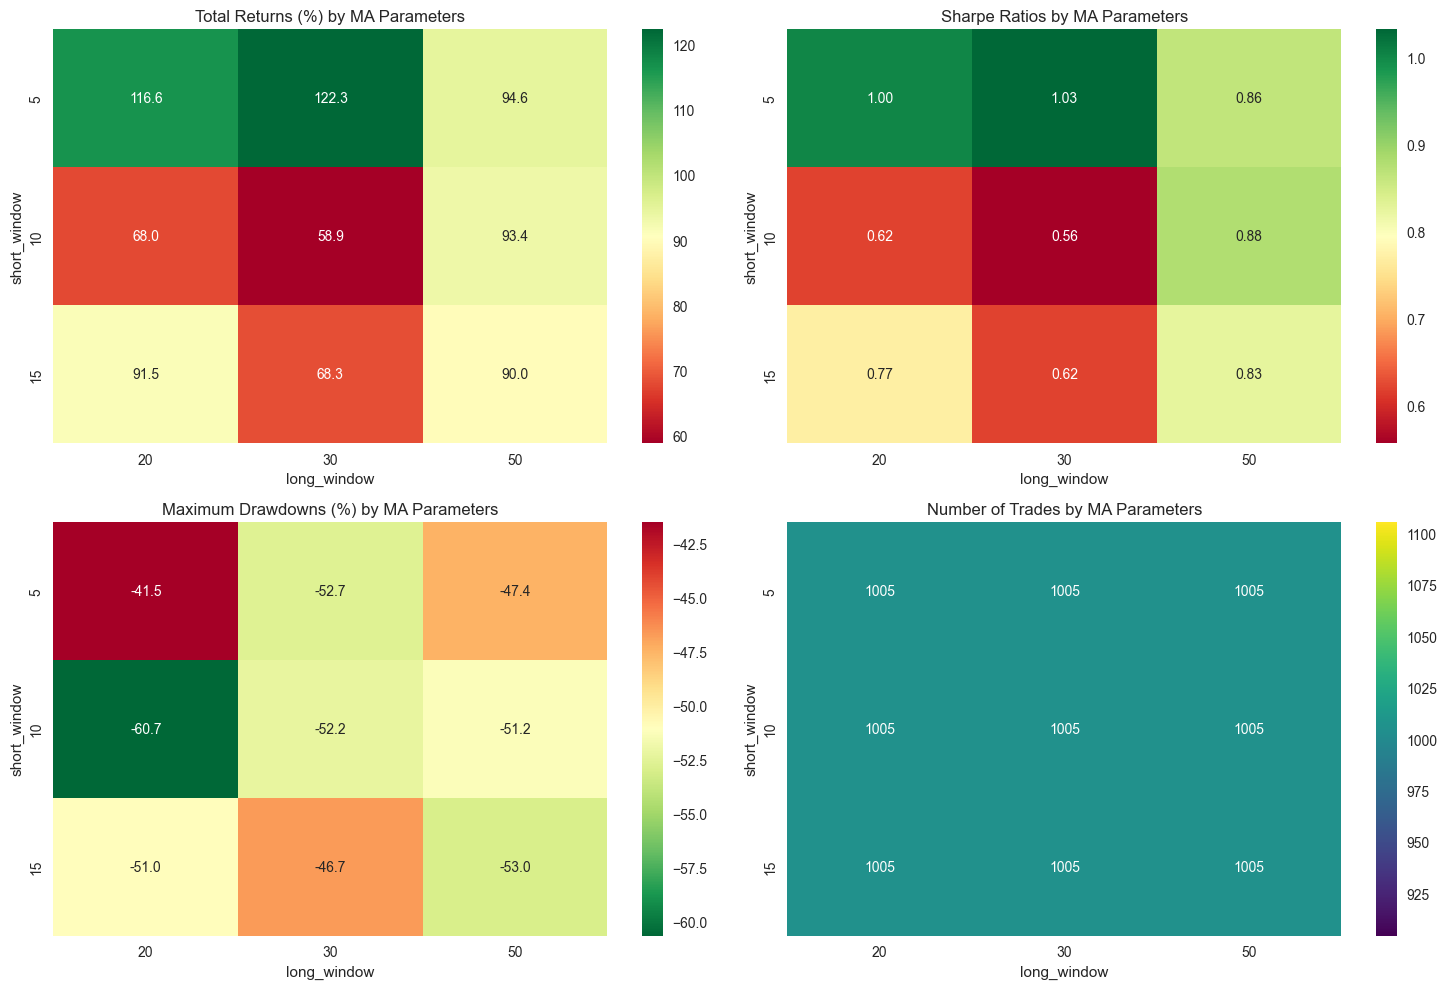


Best MA Cross parameters (Sharpe ratio):
Short window: 5, Long window: 30
Sharpe ratio: 1.032
Total return: 122.34%


In [19]:
# Visualize parameter test results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Basic validation
required_cols = {'short_window', 'long_window', 'total_return', 'sharpe_ratio', 'max_drawdown', 'num_trades'}
missing_cols = required_cols - set(ma_params_results.columns)
if missing_cols:
    print(f'Missing columns in ma_params_results: {missing_cols}')
else:
    try:
        # Use pivot_table to handle potential duplicate indices
        pivot_returns = ma_params_results.pivot_table(index='short_window', columns='long_window', values='total_return', aggfunc='mean')
        sns.heatmap(pivot_returns * 100, annot=True, fmt='.1f', cmap='RdYlGn', ax=ax1)
        ax1.set_title('Total Returns (%) by MA Parameters')

        pivot_sharpe = ma_params_results.pivot_table(index='short_window', columns='long_window', values='sharpe_ratio', aggfunc='mean')
        sns.heatmap(pivot_sharpe, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax2)
        ax2.set_title('Sharpe Ratios by MA Parameters')

        pivot_dd = ma_params_results.pivot_table(index='short_window', columns='long_window', values='max_drawdown', aggfunc='mean')
        sns.heatmap(pivot_dd * 100, annot=True, fmt='.1f', cmap='RdYlGn_r', ax=ax3)
        ax3.set_title('Maximum Drawdowns (%) by MA Parameters')

        pivot_trades = ma_params_results.pivot_table(index='short_window', columns='long_window', values='num_trades', aggfunc='sum')
        sns.heatmap(pivot_trades, annot=True, fmt='d', cmap='viridis', ax=ax4)
        ax4.set_title('Number of Trades by MA Parameters')

        plt.tight_layout()
        plt.show()

        # Best parameters (based on average Sharpe if duplicates)
        best_idx = ma_params_results.groupby(['short_window', 'long_window'])['sharpe_ratio'].mean().idxmax()
        best_params = {'short_window': best_idx[0], 'long_window': best_idx[1]}
        # Get corresponding row (average metrics) for display
        grouped = ma_params_results.groupby(['short_window', 'long_window']).mean().reset_index()
        best_row = grouped[(grouped['short_window'] == best_params['short_window']) & (grouped['long_window'] == best_params['long_window'])].iloc[0]
        print(f"\nBest MA Cross parameters (Sharpe ratio):")
        print(f"Short window: {int(best_row['short_window'])}, Long window: {int(best_row['long_window'])}")
        print(f"Sharpe ratio: {best_row['sharpe_ratio']:.3f}")
        print(f"Total return: {best_row['total_return']*100:.2f}%")
    except Exception as e:
        print('Error generating heatmaps:', e)

=== Walk-Forward Analysis ===
Number of tested periods: 11
Average return per period: 1.17%
Average Sharpe ratio: 0.544
Return standard deviation: 9.13%
Positive periods: 4/11


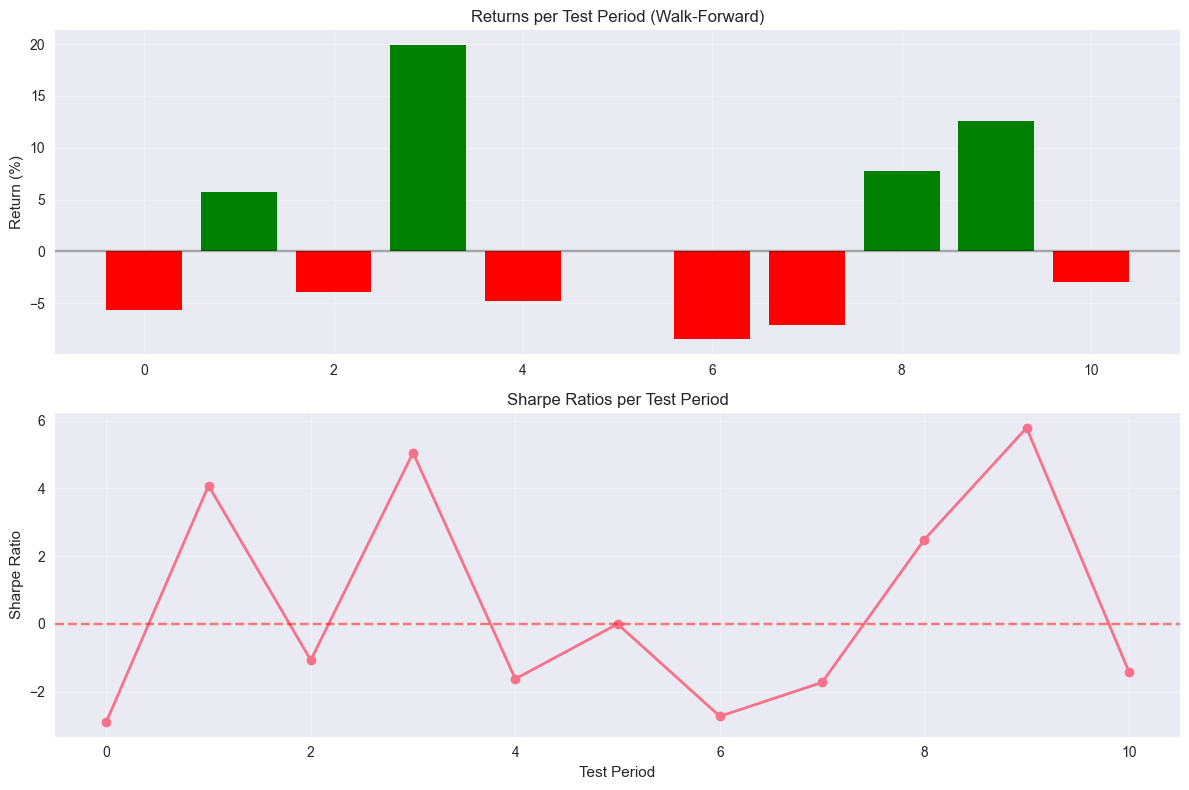

In [20]:
# Walk-forward analysis for temporal robustness validation
def walk_forward_analysis(strategy_class, strategy_params, train_months=12, test_months=3):
    """Perform walk-forward analysis of a strategy."""
    
    results = []
    start_date = pd.to_datetime('2020-01-01')
    end_date = pd.to_datetime('2023-12-31')
    
    current_date = start_date
    
    while current_date + pd.DateOffset(months=train_months + test_months) <= end_date:
        # Training period
        train_start = current_date
        train_end = current_date + pd.DateOffset(months=train_months)
        
        # Test period
        test_start = train_end
        test_end = train_end + pd.DateOffset(months=test_months)
        
        # Create and test strategy
        strategy = strategy_class(**strategy_params)
        
        try:
            result = backtester.run_backtest(
                strategy,
                start_date=test_start.strftime('%Y-%m-%d'),
                end_date=test_end.strftime('%Y-%m-%d')
            )
            
            results.append({
                'test_start': test_start,
                'test_end': test_end,
                'total_return': result.metrics['total_return'],
                'sharpe_ratio': result.metrics['sharpe_ratio'],
                'max_drawdown': result.metrics['max_drawdown'],
                'num_trades': result.metrics['num_trades']
            })
        except:
            # Ignore periods with insufficient data
            pass
        
        current_date += pd.DateOffset(months=test_months)
    
    return pd.DataFrame(results)

# Walk-forward test on MA Cross strategy
wf_results = walk_forward_analysis(
    MovingAverageCrossStrategy, 
    {'short_window': 10, 'long_window': 30},
    train_months=12,
    test_months=3
)

if len(wf_results) > 0:
    print("=== Walk-Forward Analysis ===")
    print(f"Number of tested periods: {len(wf_results)}")
    print(f"Average return per period: {wf_results['total_return'].mean()*100:.2f}%")
    print(f"Average Sharpe ratio: {wf_results['sharpe_ratio'].mean():.3f}")
    print(f"Return standard deviation: {wf_results['total_return'].std()*100:.2f}%")
    print(f"Positive periods: {(wf_results['total_return'] > 0).sum()}/{len(wf_results)}")
    
    # Walk-forward visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Returns per period
    ax1.bar(range(len(wf_results)), wf_results['total_return'] * 100, 
           color=['green' if x > 0 else 'red' for x in wf_results['total_return']])
    ax1.set_title('Returns per Test Period (Walk-Forward)')
    ax1.set_ylabel('Return (%)')
    ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax1.grid(True, alpha=0.3)
    
    # Sharpe ratios per period
    ax2.plot(range(len(wf_results)), wf_results['sharpe_ratio'], marker='o', linewidth=2)
    ax2.set_title('Sharpe Ratios per Test Period')
    ax2.set_ylabel('Sharpe Ratio')
    ax2.set_xlabel('Test Period')
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("Not enough data for walk-forward analysis")

--- Walk-Forward: Simple ML Strategy ---
Tested periods: 11
Average return per period: -0.61%
Average Sharpe: -0.056
Positive periods: 5/11


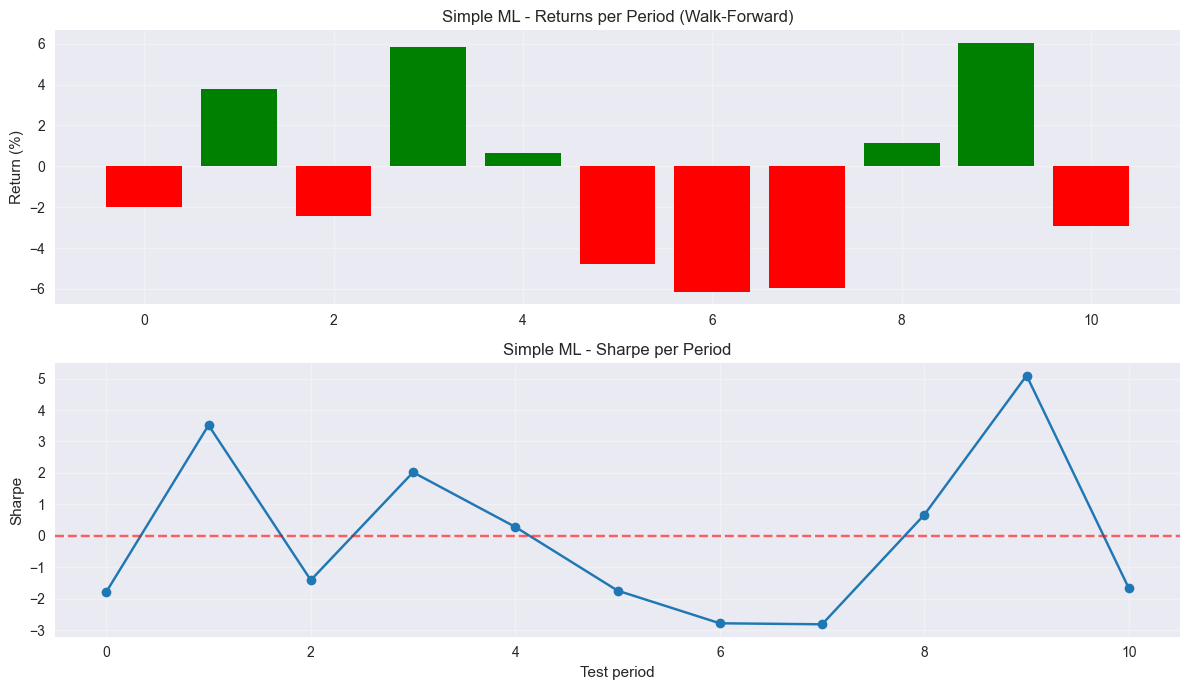

In [21]:
# Walk-forward test on Simple ML Strategy
# Uses the same walk_forward_analysis function defined above
try:
    print("--- Walk-Forward: Simple ML Strategy ---")
    wf_ml = walk_forward_analysis(SimpleMLStrategy, {}, train_months=12, test_months=3)
    
    if not wf_ml.empty:
        print(f"Tested periods: {len(wf_ml)}")
        print(f"Average return per period: {wf_ml['total_return'].mean()*100:.2f}%")
        print(f"Average Sharpe: {wf_ml['sharpe_ratio'].mean():.3f}")
        print(f"Positive periods: {(wf_ml['total_return'] > 0).sum()}/{len(wf_ml)}")
        
        # Simple visualization
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7))
        ax1.bar(range(len(wf_ml)), wf_ml['total_return'] * 100, color=['green' if x>0 else 'red' for x in wf_ml['total_return']])
        ax1.set_title('Simple ML - Returns per Period (Walk-Forward)')
        ax1.set_ylabel('Return (%)')
        ax1.grid(True, alpha=0.3)
        
        ax2.plot(range(len(wf_ml)), wf_ml['sharpe_ratio'], marker='o', linestyle='-', color='tab:blue')
        ax2.set_title('Simple ML - Sharpe per Period')
        ax2.set_xlabel('Test period')
        ax2.set_ylabel('Sharpe')
        ax2.axhline(0, color='red', linestyle='--', alpha=0.6)
        ax2.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print('Not enough periods returned by walk_forward_analysis for Simple ML')
except Exception as e:
    print('Error during Simple ML walk-forward:', e)